# Exploring COVID-19 tests using webscraping and Bayes' Theorem
First, let's import the necessary libraries

In [1]:
from bs4 import BeautifulSoup #webscraping
import requests #webscraping
import matplotlib.pyplot as plt #plotting/saving figures
import seaborn as sns #plotting
import pandas as pd #handling data
import numpy as np #math with arrays

Below I get the html code from the website. Uncomment the print statement to see what this looks like raw

In [2]:
url = 'https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(21)00048-7/fulltext'
response = requests.get(url)
# print(response.text)

In the next few cells, I extract the data that I want

In [3]:
soup = BeautifulSoup(response.text, 'lxml')
table = soup.find_all('tbody')[0].find_all('td')

In [4]:
table

[<td>Abbott BinaxNOW, USA</td>,
 <td>Nasal swab</td>,
 <td>0–7 days</td>,
 <td>Visual, 15 min</td>,
 <td>97%, 99%</td>,
 <td>WHO Emergency Use Listing; US FDA Emergency Use Authorization; app for results; influenza A and B tests available</td>,
 <td>Abbott Panbio, USA</td>,
 <td>Nasal swab, nasopharyngeal swab</td>,
 <td>0–7 days</td>,
 <td>Visual, 15–20min</td>,
 <td>93%, 99%</td>,
 <td>WHO Emergency Use Listing; US FDA Emergency Use Authorization pending</td>,
 <td>Access Bio CareStart, USA</td>,
 <td>Nasal swab, nasopharyngeal swab</td>,
 <td>0–5 days</td>,
 <td>Visual, 15–20min</td>,
 <td>88%, 100%</td>,
 <td>US FDA Emergency Use Authorization</td>,
 <td>BD Veritor, USA</td>,
 <td>Nasal swab</td>,
 <td>0–5 days</td>,
 <td>Instrument, 30 min</td>,
 <td>84%, 100%</td>,
 <td>US FDA Emergency Use Authorization</td>,
 <td>LumiraDx, UK</td>,
 <td>Nasal swab</td>,
 <td>0–12 days</td>,
 <td>Instrument, 12 min</td>,
 <td>98%, 97%</td>,
 <td>US FDA Emergency Use Authorization</td>,
 <td>Quid

In [5]:
contents = [value.text for value in table]
contents

['Abbott BinaxNOW, USA',
 'Nasal swab',
 '0–7 days',
 'Visual, 15 min',
 '97%, 99%',
 'WHO Emergency Use Listing; US FDA Emergency Use Authorization; app for results; influenza A and B tests available',
 'Abbott Panbio, USA',
 'Nasal swab, nasopharyngeal swab',
 '0–7 days',
 'Visual, 15–20min',
 '93%, 99%',
 'WHO Emergency Use Listing; US FDA Emergency Use Authorization pending',
 'Access Bio CareStart, USA',
 'Nasal swab, nasopharyngeal swab',
 '0–5 days',
 'Visual, 15–20min',
 '88%, 100%',
 'US FDA Emergency Use Authorization',
 'BD Veritor, USA',
 'Nasal swab',
 '0–5 days',
 'Instrument, 30 min',
 '84%, 100%',
 'US FDA Emergency Use Authorization',
 'LumiraDx, UK',
 'Nasal swab',
 '0–12 days',
 'Instrument, 12 min',
 '98%, 97%',
 'US FDA Emergency Use Authorization',
 'Quidel Sofia SARS Antigen Fluorescent Immunoassay, USA',
 'Nasal swab, nasopharyngeal swab',
 '0–5 days',
 'Instrument, 20 min',
 '97%, 100%',
 'US FDA Emergency Use Authorization; does not differentiate between SARS-

Here, I extract just the parts of the table that I want. There are 6 columns, and I only want information from three of them.

In [6]:
tests = [text for i, text in enumerate(contents) if i%6 == 0] #extracting the first column
sensitivities = [text.split(', ')[0] for i, text in enumerate(contents) if i%6 == 4] #extracting the fifth column
specificities = [text.split(', ')[1] for i, text in enumerate(contents) if i%6 == 4] #twice and taking different sides of the split

Now I make this data into a pandas DataFrame

In [7]:
df = pd.DataFrame({'Test_Name':tests, 'Sensitivity':sensitivities, 'Specificity':specificities})
df['Sensitivity'] = df['Sensitivity'].map(lambda x: int(x.strip('%')))/100
df['Specificity'] = df['Specificity'].map(lambda x: int(x.strip('%')))/100
df

,Test_Name,Sensitivity,Specificity
0,"Abbott BinaxNOW, USA",0.97,0.99
1,"Abbott Panbio, USA",0.93,0.99
2,"Access Bio CareStart, USA",0.88,1.00
3,"BD Veritor, USA",0.84,1.00
4,"LumiraDx, UK",0.98,0.97
5,Quidel Sofia SARS Antigen Fluorescent Immunoas...,0.97,1.00
6,Quidel Sofia Flu and SARS Antigen Fluorescent ...,0.95,1.00
7,"SD Biosensor, South Korea",0.97,1.00


Here I make a basic function version of Bayes' Theorem. This will come in handy to make new columns in the table

In [8]:
def bayes(pBA, pA, pBnA):
    # takes in:
    # probability of B given A (pBA)
    # probability of A (pA)
    # probability of B given not A (pBnA)
    # returns: probability of A given B
    
    return pBA*pA/(pBA*pA + pBnA*(1-pA))

In [9]:
df['P(virus|+)'] = bayes(df['Sensitivity'], 0.17, 1-df['Specificity'])
df['P(virus|-)'] = bayes(1-df['Sensitivity'], 0.17, df['Specificity'])

Here are those new columns

In [10]:
df.sort_values('P(virus|+)', ascending = False, inplace = True)
df

,Test_Name,Sensitivity,Specificity,P(virus|+),P(virus|-)
2,"Access Bio CareStart, USA",0.88,1.00,1.000000,0.023989
3,"BD Veritor, USA",0.84,1.00,1.000000,0.031731
5,Quidel Sofia SARS Antigen Fluorescent Immunoas...,0.97,1.00,1.000000,0.006107
6,Quidel Sofia Flu and SARS Antigen Fluorescent ...,0.95,1.00,1.000000,0.010137
7,"SD Biosensor, South Korea",0.97,1.00,1.000000,0.006107
0,"Abbott BinaxNOW, USA",0.97,0.99,0.952079,0.006168
1,"Abbott Panbio, USA",0.93,0.99,0.950120,0.014275
4,"LumiraDx, UK",0.98,0.97,0.869974,0.004205


Now, I'll make two plots: One of the probability of having the virus given a positive result for each test, and one of the probability of having the virus given a negative result for each test.

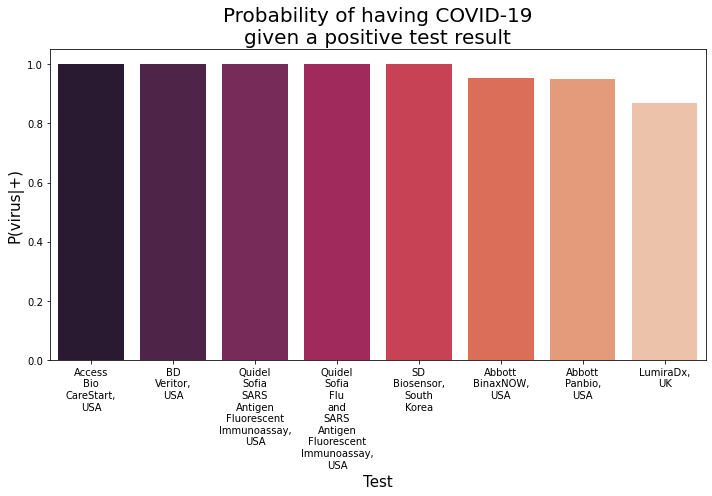

In [11]:
fig, ax = plt.subplots(figsize = (10,7))
sns.barplot(x=df['Test_Name'].map(lambda x: x.replace(' ','\n')), y=df['P(virus|+)'], ax=ax, palette = 'rocket')
ax.set_xlabel('Test', fontsize = 15)
ax.set_ylabel('P(virus|+)', fontsize = 15)
ax.set_title('Probability of having COVID-19\ngiven a positive test result', fontsize = 20)
fig.tight_layout()
plt.savefig('Images/prob_v_given_pos')

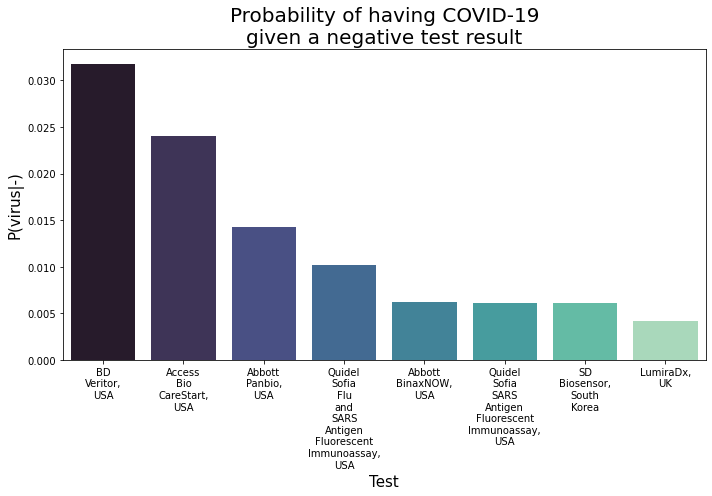

In [12]:
df.sort_values('P(virus|-)', ascending = False, inplace = True)
fig, ax = plt.subplots(figsize = (10,7))
sns.barplot(x=df['Test_Name'].map(lambda x: x.replace(' ','\n')), y=df['P(virus|-)'], ax=ax, palette = 'mako')
ax.set_xlabel('Test', fontsize = 15)
ax.set_ylabel('P(virus|-)', fontsize = 15)
ax.set_title('Probability of having COVID-19\ngiven a negative test result', fontsize = 20)
fig.tight_layout()
plt.savefig('Images/prob_v_given_neg')

Now we make a function to find the probability of having the virus given both a positive result and a negative result. I'll use the math found in the README/Medium post.

In [13]:
def v_given_p_and_n(prior, sens, spec):
    numerator = sens*(1-sens)*prior
    denominator_term_1 = (sens*prior+(1-spec)*(1-prior))
    denominator_term_2 = 1-denominator_term_1
    return numerator/(denominator_term_1*denominator_term_2)

v_given_p_and_n(0.17, 0.97, 0.99) #testing with math from the main post

0.034545664801885145

Now let's construct a DataFrame that contains the probability of having the virus having a positive and negative test result for different priors and different tests

In [14]:
chances = {}
for row in range(len(df)): # each row is a different test
    row = df.iloc[row]
    probabilities = []
    for prior in np.array(range(10, 91))*0.01: # constructing priors from 0.10 to 0.90
        probabilities.append(v_given_p_and_n(prior, row['Sensitivity'], row['Specificity'])) #making use of the earlier function
    chances[row['Test_Name']] = probabilities

chances = pd.DataFrame(chances) # creating DataFrame from the dictionary
chances.index = np.array(range(10,91))*0.01
chances = chances.stack().reset_index() # Turning priors and test names into columns
chances.columns = ['prior','Test Name','Probability'] # setting column names
chances

,prior,Test Name,Probability
0,0.1,"BD Veritor, USA",0.174672
1,0.1,"Access Bio CareStart, USA",0.131579
2,0.1,"Abbott Panbio, USA",0.071073
3,0.1,Quidel Sofia Flu and SARS Antigen Fluorescent ...,0.055249
4,0.1,"Abbott BinaxNOW, USA",0.030708
...,...,...,...
643,0.9,Quidel Sofia Flu and SARS Antigen Fluorescent ...,0.344828
644,0.9,"Abbott BinaxNOW, USA",0.237823
645,0.9,Quidel Sofia SARS Antigen Fluorescent Immunoas...,0.236220
646,0.9,"SD Biosensor, South Korea",0.236220


Now we plot it!

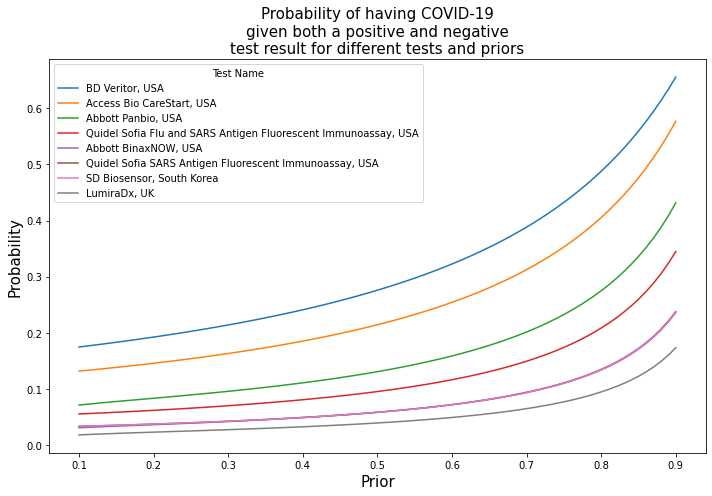

In [15]:
fig, ax = plt.subplots(figsize = (10,7))
sns.lineplot(data = chances, x = 'prior', y = 'Probability', hue = 'Test Name')
ax.set_title(
    '''Probability of having COVID-19
given both a positive and negative
test result for different tests and priors''',
fontsize = 15)
ax.set_xlabel('Prior', fontsize = 15)
ax.set_ylabel('Probability', fontsize = 15)
fig.tight_layout()
plt.savefig('Images/prob_v_given_pos_neg')